# Introduction

![](https://miro.medium.com/max/550/1*BbF4o_uKCRKerXpZiJBlpg.png)

***The process of Neural Machine Translation was widely infulenced from the innovations done by Britishers during World War 2 in breaking the Enigma code. Later this process was adopted by US agencies to keep a track of Russian innovations through translation of their published papers***

# What is Machine Translation?
**Machine translation is the task of automatically converting source text in one language to text in another language.**

***In a machine translation task, the input already consists of a sequence of symbols in some language, and the computer program must convert this into a sequence of symbols in another language.***


**Given a sequence of text in a source language, there is no one single best translation of that text to another language. This is because of the natural ambiguity and flexibility of human language. This makes the challenge of automatic machine translation difficult, perhaps one of the most difficult in artificial intelligence:**

***The fact is that accurate translation requires background knowledge in order to resolve ambiguity and establish the content of the sentence.***

**Classical machine translation methods often involve rules for converting text in the source language to the target language. The rules are often developed by linguists and may operate at the lexical, syntactic, or semantic level. This focus on rules gives the name to this area of study: Rule-based Machine Translation, or RBMT.**

***RBMT is characterized with the explicit use and manual creation of linguistically informed rules and representations.***

**The key limitations of the classical machine translation approaches are both the expertise required to develop the rules, and the vast number of rules and exceptions required.**

**For more details refer [here](https://machinelearningmastery.com/introduction-neural-machine-translation/)**

**For Implementation simplicity I'll be refereing to [keras](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py) documentation for this**

**Happy Learning**

**To get started watch this video of Siraj Raval on Machine Translation!!**

**bonne chance**

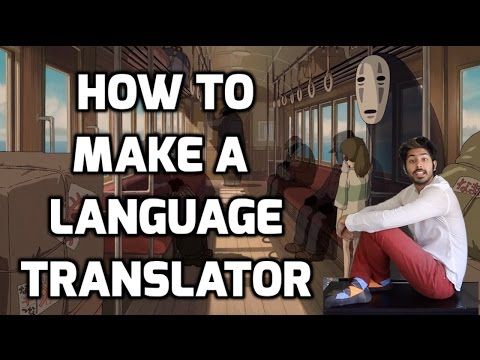

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('nRBnh4qbPHI',width=800, height=450)

# Loading Libraries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from keras.models import Model
from keras.layers import Input, LSTM, Dense, GRU
import matplotlib.pyplot as plt
import seaborn as sns
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading Dataset

In [3]:
data_dir = '../input/frenchenglish/'
os.listdir(data_dir)

['fra.txt', '_about.txt']

In [4]:
path = '../input/frenchenglish/fra.txt'
batch_size = 128
epochs=100
latent_dim=256
num_samples=10000

In [5]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()


with open(path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    
    
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            
            
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [6]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [7]:
print('Number of samples:', len(input_texts))

print('Number of unique input tokens:', num_encoder_tokens)

print('Number of unique output tokens:', num_decoder_tokens)

print('Max sequence length for inputs:', max_encoder_seq_length)

print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [8]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [9]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            '''
            decoder_target_data will be ahead by one timestep
            and will not include the start character.
            
            '''
            
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

# Model Developement

**We start by defining Encoder and Decoder, Encoder will recieve words in english while Decoder will play the role of translator to the words**

In [10]:
#Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [11]:
#Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [12]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/100
63/63 [==============================] - 2s 31ms/step - loss: 1.3411 - accuracy: 0.7158 - val_loss: 1.1903 - val_accuracy: 0.6983
Epoch 2/100
63/63 [==============================] - 1s 17ms/step - loss: 0.9940 - accuracy: 0.7373 - val_loss: 1.0188 - val_accuracy: 0.7163
Epoch 3/100
63/63 [==============================] - 1s 17ms/step - loss: 0.8746 - accuracy: 0.7642 - val_loss: 0.9021 - val_accuracy: 0.7602
Epoch 4/100
63/63 [==============================] - 1s 18ms/step - loss: 0.7564 - accuracy: 0.7938 - val_loss: 0.7965 - val_accuracy: 0.7748
Epoch 5/100
63/63 [==============================] - 1s 17ms/step - loss: 0.6701 - accuracy: 0.8102 - val_loss: 0.7346 - val_accuracy: 0.7943
Epoch 6/100
63/63 [==============================] - 1s 17ms/step - loss: 0.6145 - accuracy: 0.8226 - val_loss: 0.6815 - val_accuracy: 0.8004
Epoch 7/100
63/63 [==============================] - 1s 18ms/step - loss: 0.5775 - accuracy: 0.8313 - val_loss: 0.6481 - val_accuracy: 0.8091
Epoch 

# Save Model

In [13]:
model.save('s2s.h5')

# Inference stage
**Now we begin with Inference mode or sampling mode, The process can be summarized below**
1. **Encode input and retrieve initial decoder state**
2. **Run one step of decoder with this initial state and a "start of sequence" token as target. Output will be the next target token**
3. **Repeat with the current target token and current states**

In [14]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [15]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [16]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


# Prédiction

In [17]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: C'est pourique !

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Who?
Decoded sentence: Qui ?

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À llair !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Hello!
Decoded sentence: Bonjour !

-
Input se